# Expectation Maximization (EM) for Gaussian Mixture Models (GMMs)

EM algorithm fits a GMM 

$$\theta \sim \sum_{i=c}^k \pi_c N(\mu_c, \Sigma_c)$$

from particle positions $\{\theta_i\}$ and corresponding weights $\{w_i\}$, and the source/cluster number $k$. 

In [127]:
using LinearAlgebra
function gaussian_density(x::Array{FT}, mean::Array{FT, 1}, covariance::Array{FT, 2}) where {FT<:AbstractFloat}
    d = size(x)[1]
    ρ = exp(-0.5* ((x - mean)' * (covariance\(x - mean)))) / ( (2π)^(d/2)*sqrt(det(covariance)) )
    return ρ
end

function log_likelihood(xs::Array{FT,2}, ws::Array{FT}, weights::Array{FT}, means::Array{FT, 2}, covariances::Array{FT, 3}) where {FT<:AbstractFloat}
    L = 0.0
    
    Nx, d = size(xs)
    Nc, _ = size(means)
    
    for i = 1:Nx
        r = 0.0
        for c = 1:Nc
            r += weights[c] * gaussian_density(xs[i,:], means[c,:], covariances[c,:,:])
        end
        L += ws[i]*log(r)
    end
    
    return L
end

function expectaion_step(xs::Array{FT,2}, ws::Array{FT}, weights::Array{FT}, means::Array{FT, 2}, covariances::Array{FT, 3}) where {FT<:AbstractFloat}
    
    Nx, d = size(xs)
    Nc, _ = size(means)
    
    r = zeros(Nx, Nc)
    for i = 1:Nx
        for c = 1:Nc
            r[i,c] = weights[c] * gaussian_density(xs[i,:], means[c,:], covariances[c,:,:])
            
            # @show xs[i,:], means[c,:], covariances[c,:,:], weights[c], r[i,c]
        end
        r[i, :] /= sum(r[i, :])
    end

    return r
end


function maximization_step!(xs::Array{FT,2}, ws::Array{FT}, r::Array{FT,2}, weights::Array{FT}, means::Array{FT, 2}, covariances::Array{FT, 3}) where {FT<:AbstractFloat}
    
    Nx, d = size(xs)
    Nc, _ = size(means)
    
    for c = 1:Nc
        rc = ws .* r[:,c]
        weights[c] = sum(rc)
        
        means[c,:] = rc' * xs / weights[c]

        @info "In maximization_step! means = ", means
        covariances[c,:,:] = (xs - ones(Nx)*means[c,:]')' * Diagonal(rc) * (xs - ones(Nx)*means[c,:]') / weights[c]
    end
    
    weights ./= sum(weights)
end
    

function EM_iteration(xs::Array{FT,2}, ws::Array{FT}, Nc::IT; max_iter::IT = 100, eps::FT = 1.0e-8) where {FT<:AbstractFloat, IT<:Int}
    d = size(xs)[2]
    weights = zeros(Nc)
    means = zeros(Nc, d)
    covariances = zeros(Nc, d, d)
    for c = 1:Nc
        weights[c] = 1.0/Nc
        means[c, :] .= c
        covariances[c, :, :] = Matrix(c*I, d, d)
    end
    
    L, L_old, δL = -Inf, -Inf, 0

    for i = 1:max_iter
        r = expectaion_step(xs, ws, weights, means, covariances)
        
        @info "r = ", r
#         error("stop")
        maximization_step!(xs, ws, r, weights, means, covariances)
        
        @info "weights = ", weights
        @info "means = ", means
        @info "covariances = ", covariances[1, :, :], covariances[2, :, :]


        L_old = L
        L = log_likelihood(xs, ws, weights, means, covariances)
        δL = L - L_old
        @info "EM iterations: ", i, " log likelihood: ", L, " δlog likelihood: ",  δL
        
        if δL < eps
            @info "Converged! ", δL, " < ", eps
            break
        end
        
        
    end
    
    
    return weights, means, covariances
end

EM_iteration (generic function with 1 method)

# Sampling from the Gaussian Mixture Model

In [128]:
function sample_GMM!(weights::Array{FT}, means::Array{FT, 2}, covariances::Array{FT, 3}; N_ens::IT = 2*size(means)[2]+1) where {FT<:AbstractFloat, IT<:Int}
    
    
    Nc, d = size(means)
    
    @assert(N_ens == 2d+1)
    
    xs = zeros(Nc, N_ens, d)
    ws = zeros(Nc, N_ens)
    # α = sqrt((N_ens-1)/2.0)
    α = sqrt(N_ens/2.0)
    for c = 1:Nc
        chol_xx_cov = cholesky(Hermitian(covariances[c,:,:])).L
        xs[c, 1, :] = means[c, :]
       
        for i = 1: d
            xs[c, i+1,     :] = means[c, :] + α*chol_xx_cov[:,i]
            xs[c, i+1+d, :]   = means[c, :] - α*chol_xx_cov[:,i]
        end
        
        ws[c, :] .= weights[c]
    end
    
    return xs, ws
    
end

sample_GMM! (generic function with 1 method)

In [129]:
# Test
d = 2
Nc = 2
weights = [0.3;0.7] 
means = [1.0 0.0; 2.0 3.0]
covariances = zeros(Nc, d, d)
covariances[1,:,:] .= [1.0 0.0; 0.0 2.0]
covariances[2,:,:] .= [2.0 0.0; 0.0 3.0]

xs, ws = sample_GMM!(weights, means, covariances)
# @info xs[1,1,:], xs[2,1,:], xs[1,2,:], xs[2,2,:]
# @info reshape(xs, (size(xs,1)*size(xs,2), d))[1,:]
# @info reshape(xs, (size(xs,1)*size(xs,2), d))[2,:]
# @info reshape(xs, (size(xs,1)*size(xs,2), d))[3,:]
# @info reshape(xs, (size(xs,1)*size(xs,2), d))[4,:]
em_weights, em_means, em_covariances = EM_iteration(reshape(xs, (size(xs,1)*size(xs,2), d)), reshape(ws, size(xs,1)*size(xs,2)), Nc) 

@info "weights, em_weights: ", weights, em_weights
@info "means, em_means: ", means, em_means
@info "covariances, em_covariances: ", covariances, em_covariances

(xs[i, :], means[c, :], covariances[c, :, :], weights[c], r[i, c]) = ([1.0, 0.0], [0.0, 0.0], [1.0 0.0; 0.0 1.0], 0.5, 0.46175323586155426)
(xs[i, :], means[c, :], covariances[c, :, :], weights[c], r[i, c]) = ([1.0, 0.0], [0.0, 0.0], [1.0 0.0; 0.0 1.0], 0.5, 0.46175323586155426)
(xs[i, :], means[c, :], covariances[c, :, :], weights[c], r[i, c]) = ([2.0, 3.0], [0.0, 0.0], [1.0 0.0; 0.0 1.0], 0.5, 0.17770075223488233)
(xs[i, :], means[c, :], covariances[c, :, :], weights[c], r[i, c]) = ([2.0, 3.0], [0.0, 0.0], [1.0 0.0; 0.0 1.0], 0.5, 0.17770075223488233)
(xs[i, :], means[c, :], covariances[c, :, :], weights[c], r[i, c]) = ([2.0, 0.0], [0.0, 0.0], [1.0 0.0; 0.0 1.0], 0.5, 0.36368867464760823)
(xs[i, :], means[c, :], covariances[c, :, :], weights[c], r[i, c]) = ([2.0, 0.0], [0.0, 0.0], [1.0 0.0; 0.0 1.0], 0.5, 0.36368867464760823)
(xs[i, :], means[c, :], covariances[c, :, :], weights[c], r[i, c]) = ([3.414213562373095, 3.0], [0.0, 0.0], [1.0 0.0; 0.0 1.0], 0.5, 0.0966202036778958)
(xs[i, 

┌ Info: [0.5 0.5; 0.5 0.5; 0.5 0.5; 0.5 0.5; 0.5 0.5; 0.5 0.5; 0.5 0.5; 0.5 0.5; 0.5 0.5; 0.5 0.5]
└ @ Main In[127]:75
┌ Info: ("EM iterations: ", 1, " log likelihood: ", -1.1250360864586342, " δlog likelihood: ", Inf)
└ @ Main In[127]:82
┌ Info: [0.5 0.5; 0.5 0.5; 0.5 0.5; 0.5 0.5; 0.5 0.5; 0.5 0.5; 0.5 0.5; 0.5 0.5; 0.5 0.5; 0.5 0.5]
└ @ Main In[127]:75
┌ Info: ("EM iterations: ", 2, " log likelihood: ", -1.1250360864586342, " δlog likelihood: ", 0.0)
└ @ Main In[127]:82
┌ Info: ("Converged! ", 0.0, " < ", 1.0e-8)
└ @ Main In[127]:85
┌ Info: ("weights, em_weights: ", [0.3, 0.7], [0.5, 0.5])
└ @ Main In[129]:18
┌ Info: ("means, em_means: ", [1.0 0.0; 2.0 3.0], [1.6999999999999997 2.0999999999999996; 1.6999999999999997 2.0999999999999996])
└ @ Main In[129]:19
┌ Info: ("covariances, em_covariances: ", [1.0 0.0; 2.0 0.0;;; 0.0 2.0; 0.0 3.0], [0.8899999999999999 0.6299999999999999; 0.8899999999999999 0.6299999999999999;;; 0.63 2.9699999999999998; 0.63 2.9699999999999998])
└ @ Main In[129]

In [1]:
using Random
using Distributions
using LinearAlgebra
include("../Inversion/Plot.jl")
include("../Inversion/GMKI.jl")
include("../Inversion/KI.jl")
include("../Inversion/RWMCMC.jl")
include("../Inversion/SMC.jl")
include("../Inversion/KalmanInversion.jl")

solve_β (generic function with 2 methods)

In [2]:
function Posterior_Plot(forward::Function, forward_aug::Function;  θ_ref = 2.0, σ_η = 0.1, μ_0 = 3.0,  σ_0 = 2.0)
    N_y, N_θ = 1, 1
    s_param = Setup_Param(N_θ, N_y)
    y = forward(s_param, [θ_ref;])
    Σ_η = reshape([σ_η^2], (N_y, N_y))
    
    # prior distribution
    μ0,  Σ0   = [μ_0;], reshape([σ_0^2],  (N_θ, N_θ))
    
    
    # compute posterior distribution by MCMC
    logρ(θ) = log_bayesian_posterior(s_param, θ, forward, y, Σ_η, μ0, Σ0) 
    step_length = 1.0
    N_iter , n_burn_in= 5000000, 1000000
    us = RWMCMC_Run(logρ, μ0, step_length, N_iter)
 
    
    # compute posterior distribution by SMC
    N_ens = 1000
    M_threshold = Float64(N_ens)
    N_t = 100
    step_length = 1.0
    smcobj = SMC_Run(s_param, forward,
    μ0, Σ0, 
    y, Σ_η,
    N_ens, 
    step_length,
    M_threshold,
    N_t) 
    
    N_iter = 100
    N_ens  = 1000
    eksobj = EKS_Run(s_param, forward, 
    μ0, Σ0,
    N_ens,
    y, Σ_η,
    N_iter)
    
    @info "EKS large J t = ", sum(eksobj.Δt)
    
    # compute posterior distribution by UKI
    update_freq = 1
    N_iter = 20
    
    N_modes = 2
    θ0_w  = [0.5; 0.5]
    θ0_mean, θθ0_cov  = zeros(N_modes, N_θ), zeros(N_modes, N_θ, N_θ)
    
    θ0_mean[1, :]    .= -3.0
    θθ0_cov[1, :, :] .=  reshape([0.5^2],  (1, 1))
    θ0_mean[2, :]    .=  3.0
    θθ0_cov[2, :, :] .=  reshape([0.5^2],  (1, 1))
    
    s_param_aug = Setup_Param(1,2)
    y_aug = [y ; μ0]
    Σ_η_aug = [Σ_η zeros(Float64, N_y, N_θ); zeros(Float64, N_θ, N_y) Σ0]
    γ = 1.0
    ukiobj = GMUKI_Run(s_param_aug, forward_aug, θ0_w, θ0_mean, θθ0_cov, y_aug, Σ_η_aug, γ, update_freq, N_iter; unscented_transform="modified-2n+1")
    
    # visualization 
    nrows, ncols = 1, 1
    fig, ax = PyPlot.subplots(nrows=nrows, ncols=ncols, sharex=true, sharey=true, figsize=(6,6))
    # plot UKI results 

    for i =1:N_modes
        if i == 1
            marker, linestyle, label, color =  "o", "-", "UKI (m₀=-1)" , "C1"
        else
            marker, linestyle, label, color =  "*", ":", "UKI (m₀=1)" , "C2"
        end
        Nx = 1000
        xx, zz = Gaussian_1d(ukiobj.θ_mean[end][i,1], ukiobj.θθ_cov[end][i,1,1], Nx)
        ax.plot(xx, exp(ukiobj.logθ_w[end][i])*zz, marker= marker,linestyle=linestyle, color=color, fillstyle="none", markevery=100, label=label)
    end
    
    # plot EKS results 
    θ = eksobj.θ[end]
    ax.hist(θ, bins = 40, density = true, histtype = "step", label="EKS", color="C4")
    ax.legend()
    
    
    
    # plot MCMC results 
    ax.hist(us[n_burn_in:end, 1], bins = 100, density = true, histtype = "step", label="MCMC", color="C3")
    # plot SMC results 
    θ = smcobj.θ[end]
    weights = smcobj.weights[end]
    ax.hist(θ, bins = 20, weights = weights, density = true, histtype = "step", label="SMC", color="C0")
    ax.legend()
    
    
    nrows, ncols = 1, 1
    fig, ax = PyPlot.subplots(nrows=nrows, ncols=ncols, sharex=true, sharey=true, figsize=(6,6))
    θ_w = exp.(hcat(ukiobj.logθ_w...))
    for i =1:N_modes
        ax.plot(θ_w[i, :], "--o", label="mode"*string(i))
    end
    ax.legend()
end



Posterior_Plot (generic function with 1 method)

In [6]:
mutable struct Setup_Param{IT<:Int}
    θ_names::Array{String,1}
    N_θ::IT
    N_y::IT
end

function Setup_Param(N_θ::IT, N_y::IT) where {IT<:Int}
    return Setup_Param(["θ"], N_θ, N_y)
end

function p1(s_param, θ::Array{Float64,1})  
    return [θ[1] ;]
end

function p1_aug(s_param, θ::Array{Float64,1})  
    return [θ[1] ; θ[1]]
end

function p1_aug_derivative(s_param, θ::Array{Float64,1})  
    return [θ[1] ; θ[1]], [1.0 ; 1.0]
end



function p2(s_param, θ::Array{Float64,1})  
    return [θ[1]^2 ;]
end

function p2_aug(s_param, θ::Array{Float64,1})  
    return [θ[1]^2 ; θ[1]]
end

function p2_aug_derivative(s_param, θ::Array{Float64,1})  
    return [θ[1]^2 ; θ[1]], [2θ[1] ; 1.0]
end

p2_aug_derivative (generic function with 1 method)

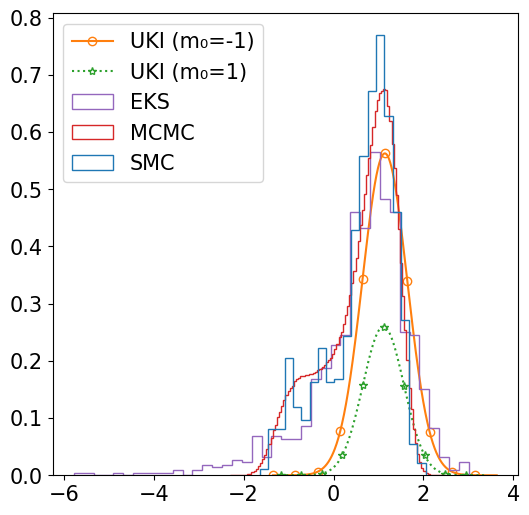

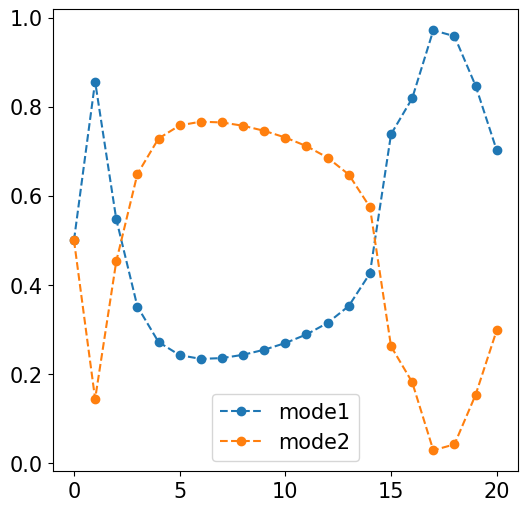

┌ Info: ("EKS large J t = ", 12.237118925808856)
└ @ Main In[2]:39
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:88


PyObject <matplotlib.legend.Legend object at 0x1b724e550>

In [102]:
Posterior_Plot(p2, p2_aug; θ_ref = 1.0, σ_η = 1.0, μ_0 = 3.0,  σ_0 = 2.0) 